Autoencoders
======

In [1]:
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

Parameter Settings
-------------------


In [26]:
latent_dims = 10
num_epochs = 50
batch_size = 128
learning_rate = 1e-3
use_gpu = False

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

In [6]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Autoencoder Definition
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [27]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=4, stride=2, padding=1) # out: 8 x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, stride=2, padding=1) # out: 16 x 7 x 7
        self.fc = nn.Linear(in_features=784, out_features=latent_dims) # 784 = 16 x 7 x 7
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=latent_dims, out_features=784)
        self.conv2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 16, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = F.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder = Autoencoder()
if use_gpu:
    autoencoder = autoencoder.cuda()

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 20859


Train Autoencoder
--------

In [28]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = Variable(image_batch)
        if use_gpu:
            image_batch = image_batch.cuda()
        
        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)
        
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.data[0]
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 0.241772
Epoch [2 / 50] average reconstruction error: 0.122048
Epoch [3 / 50] average reconstruction error: 0.103001
Epoch [4 / 50] average reconstruction error: 0.096308
Epoch [5 / 50] average reconstruction error: 0.091672
Epoch [6 / 50] average reconstruction error: 0.088162
Epoch [7 / 50] average reconstruction error: 0.085560
Epoch [8 / 50] average reconstruction error: 0.083456
Epoch [9 / 50] average reconstruction error: 0.081789
Epoch [10 / 50] average reconstruction error: 0.080401
Epoch [11 / 50] average reconstruction error: 0.079122
Epoch [12 / 50] average reconstruction error: 0.078018
Epoch [13 / 50] average reconstruction error: 0.077068
Epoch [14 / 50] average reconstruction error: 0.076219
Epoch [15 / 50] average reconstruction error: 0.075534
Epoch [16 / 50] average reconstruction error: 0.074789
Epoch [17 / 50] average reconstruction error: 0.074270
Epoch [18 / 50] average reconstruction error: 0.073632
Epoch 

Plot Training Curve
--------------------

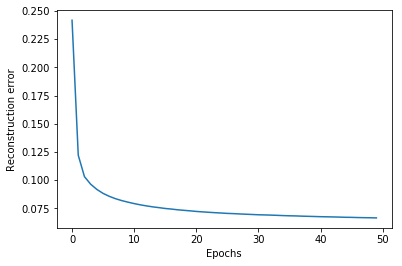

In [34]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

Alternatively: Load Pre-Trained Autoencoder
-----------------------------

In [32]:
autoencoder.load_state_dict(torch.load('./pretrained/autoencoder.pth'))

# this is how the autoencoder parameters can be saved:
# torch.save(autoencoder.state_dict(), './pretrained/autoencoder.pth')

Evaluate on the Test Set
-------------------------

In [33]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    image_batch = Variable(image_batch)
    if use_gpu:
        image_batch = image_batch.cuda()
    
    # autoencoder reconstruction
    image_batch_recon = autoencoder(image_batch)

    # reconstruction error
    loss = F.mse_loss(image_batch_recon, image_batch)

    test_loss_avg += loss.data[0]
    num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.065785


Visualize Reconstructions
--------------------------

Original images


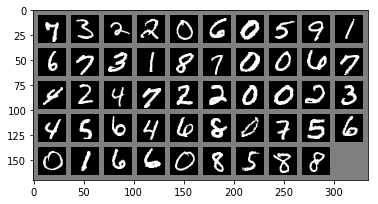

Autoencoder reconstruction:


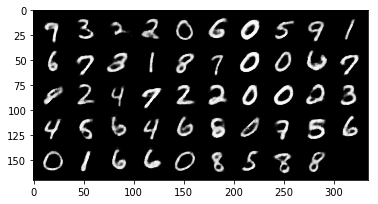

In [123]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):
    images = Variable(images)
    if use_gpu:
        images = images.cuda()
    images = model(images)
    if use_gpu:
        images = images.cpu()
    images = to_img(images.data)
    np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)

Interpolate in Latent Space
----------------------------

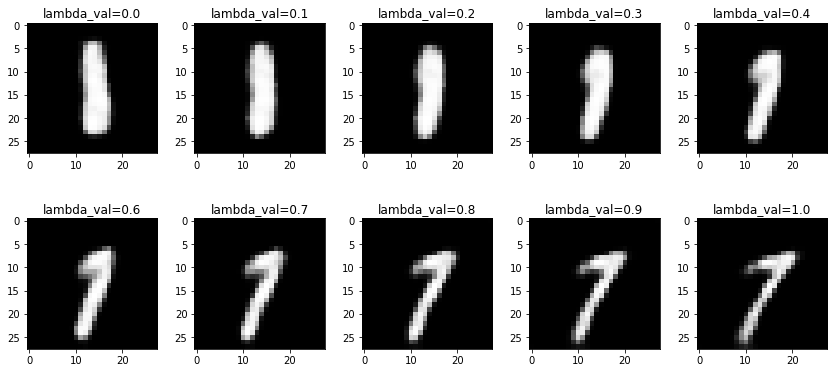

In [129]:
def interpolation(lambda1, model, img1, img2):
    
    # latent vector of first image
    img1 = Variable(img1)
    if use_gpu:
        img1 = img1.cuda()
    latent_1 = model.encoder(img1)
    
    # latent vector of second image
    img2 = Variable(img2)
    if use_gpu:
        img2 = img2.cuda()
    latent_2 = model.encoder(img2)
    
    # interpolation of the two latent vectors
    inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2
    
    # reconstruct interpolated image
    inter_image = model.decoder(inter_latent)
    if use_gpu:
        inter_image = inter_image.cpu()
    
    return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), autoencoder, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.data.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

Random Latent Vector (Autoencoder as Generator)
-------------------------------------------------

Even though interpolation works well, generating a new digit does not work that well: many latent vectors consistently decode to something that does not look like a digit. This means that the manifold of latent vectors that do decode to valid digits is sparse in latent space. With higher-dimensional latent spaces, the manifold gets sparser. Compare this to Variational Autoencoders that can more consistently generate valid digits from random samples.

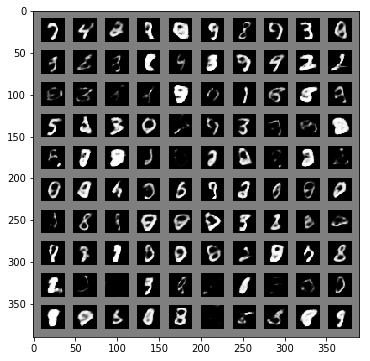

In [127]:
# approx. fit an isotropic multivariate normal distribution to the latent vectors of a random part of the test set
images, labels = iter(test_dataloader).next()
images = Variable(images)
if use_gpu:
    images = images.cuda()
latent = autoencoder.encoder(images)
if use_gpu:
    latent = latent.cpu()
latent = latent.data

mean = latent.mean(dim=0)
std = (latent - mean).pow(2).mean(dim=0).sqrt()

# sample latent vectors from the normal distribution
latent = torch.randn(128, latent_dims)*std + mean

# reconstruct images from the latent vectors
latent = Variable(latent)
if use_gpu:
    latent = latent.cuda()
img_recon = autoencoder.decoder(latent)
if use_gpu:
    img_recon = img_recon.cpu()
    
fig, ax = plt.subplots(figsize=(15, 6))
show_image(torchvision.utils.make_grid(img_recon.data[:100],10,10))
plt.show()